In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import scotia
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial import distance_matrix
from scipy.stats import ranksums
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")
import sys

In [1]:
datap = '/your/workspace/'
datap = '/data/hemberg/jingyi/project/1.pdac/cosmx_lung/'
sample_l = ['Lung5','Lung6','Lung9','Lung12','Lung13']

In [5]:
#get DBSCAN cell clusters
for sample_id in ['Lung5']:
    for fov in [10]:
        meta_df_fov = pd.read_csv(datap+'/data/'+sample_id+'_fov_'+str(fov)+'_summary.csv',header = 0,index_col = 0)
        meta_df_fov['index'] = range(meta_df_fov.shape[0])
        celltype = []
        cell_idx = []
        cell_type_l = list(set(meta_df_fov['annotation']))
        for ct in cell_type_l:
            ###cluster cells
            #print(ct)
            meta_df_sel = meta_df_fov[meta_df_fov['annotation']==ct]
            X = np.array(meta_df_sel[['CenterX_local_px','CenterY_local_px']])
            if X.shape[0] >= 10:
                print(ct)
                idx_l, fi_eps = scotia.dbscan_ff_cell(X, X_index_arr=np.array(meta_df_sel['index'])) #final
                if len(idx_l)>0:
                    celltype += [ct for x in idx_l]
                    cell_idx += idx_l
        tmp_df = pd.DataFrame([celltype,cell_idx]).T
        np.save(datap+'output/clustering/'+sample_id+'_fov_'+str(fov)+'_dbscan.cell.clusters.test',tmp_df) #final

monocyte
Bcell
eps: 65
macrophage
eps: 70
DC
eps: 105
NK
eps: 95
neutrophil
eps: 45
epithelial
eps: 80
plasmablast
eps: 85
mast
eps: 95
endothelial
eps: 65
Tcell
eps: 80
malignant
eps: 20
fibroblast
eps: 50


Lung5
Bcell


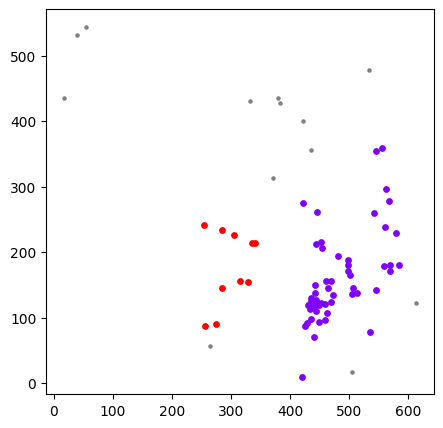

macrophage


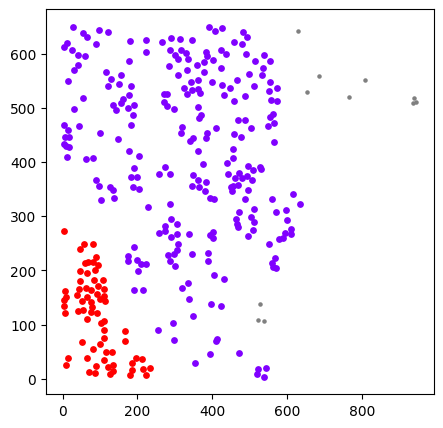

DC


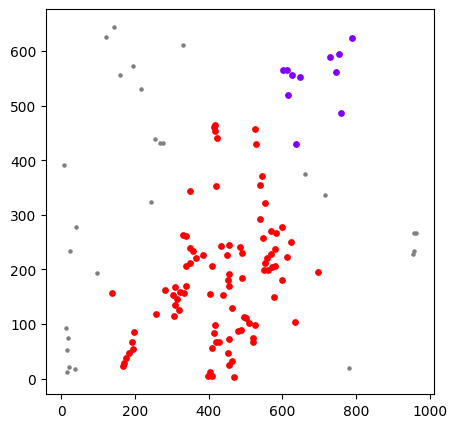

NK


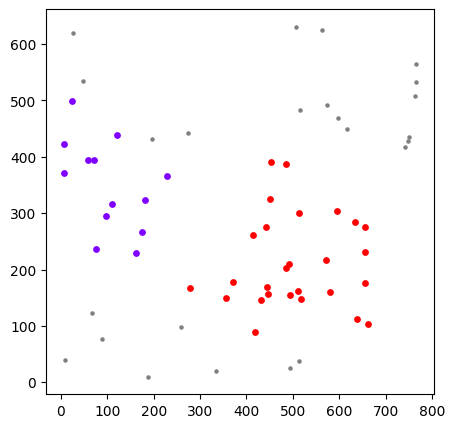

plasmablast


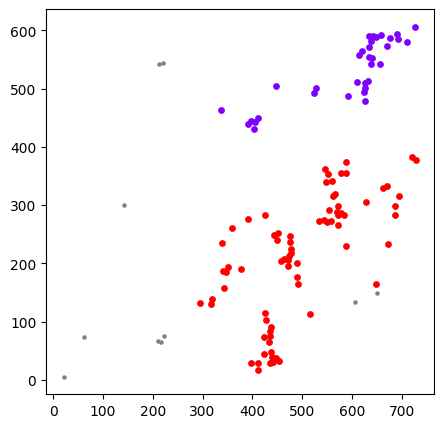

epithelial


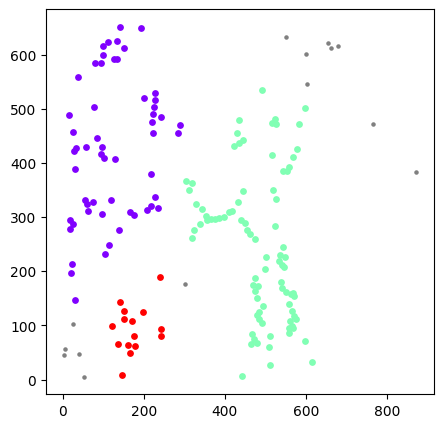

neutrophil


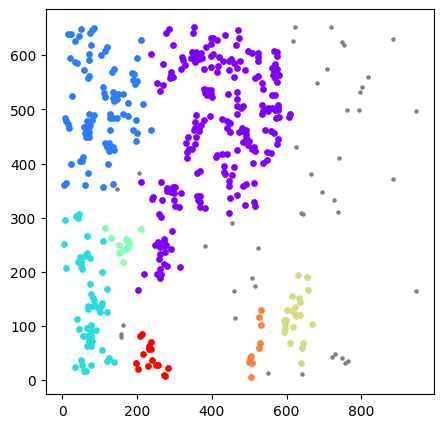

mast


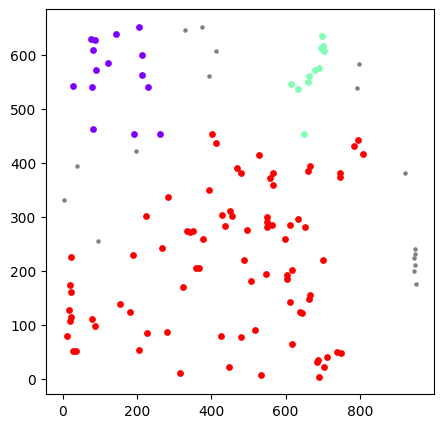

endothelial


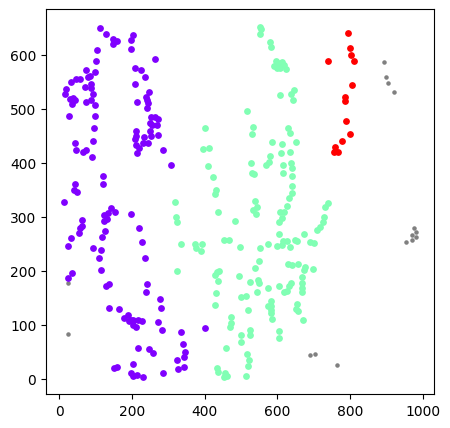

Tcell


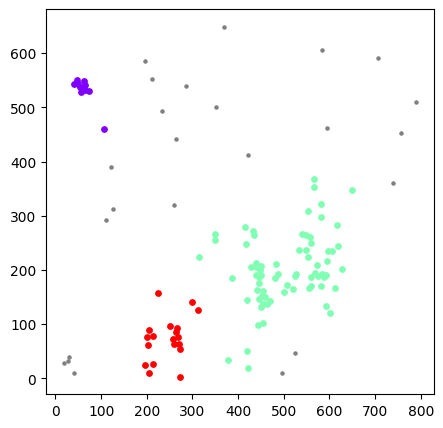

malignant


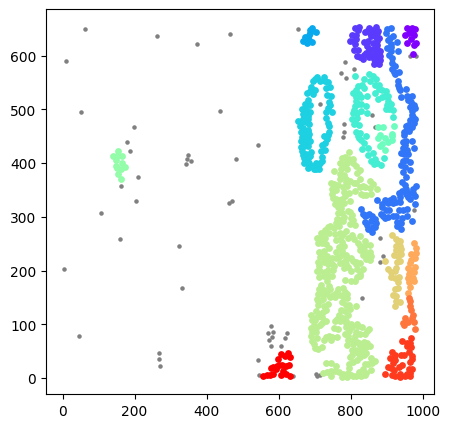

fibroblast


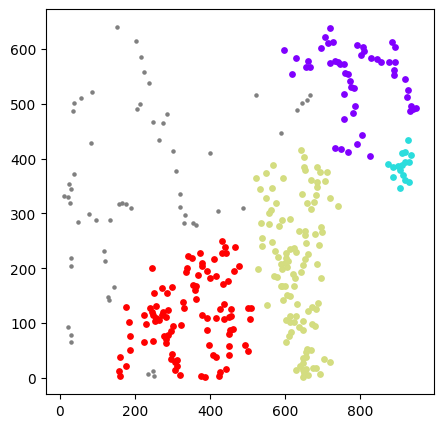

In [7]:
#visualization of DBSCAN clustering result
#legend: each dot is a cell, cells of the same color are from the same cluster, cells in the grey color are the noise identified by DBSCAN
#for fov in set(meta_df['fov']):
for sample_id in ['Lung5']:
    print(sample_id)
    for fov in [10]:
        meta_df_fov = pd.read_csv(datap+'/data/'+sample_id+'_fov_'+str(fov)+'_summary.csv',header = 0,index_col = 0)
        meta_df_fov.index = range(meta_df_fov.shape[0])
        cluster_df = pd.DataFrame(np.load(datap+'output/clustering/'+sample_id+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
        cluster_df.columns = ['cell_type','cell_idx']
        cell_type_l = list(set(cluster_df['cell_type']))
        for ct in cell_type_l:
            print(ct)
            plt.figure(figsize=(5,5))
            #plot all ct cells
            #higlight clusters for ct cells
            tmp_ct = cluster_df[cluster_df['cell_type']==ct]
            colors = cm.rainbow(np.linspace(0, 1, tmp_ct.shape[0]))
            if tmp_ct.shape[0]>0:
                meta_df_sel = meta_df_fov[meta_df_fov['annotation']==ct]
                X_sel = np.array(meta_df_sel[['CenterX_local_px','CenterY_local_px']])
                plt.scatter(X_sel[:,0],X_sel[:,1],c = 'grey',s = 5)
                for n,line in enumerate(tmp_ct['cell_idx']):
                    X = np.array(meta_df_fov.loc[line][['CenterX_local_px','CenterY_local_px']])
                    plt.scatter(X[:,0],X[:,1],color =colors[n],s = 15)
                plt.show()

In [101]:
#ot
df_quantile = pd.read_csv(datap+'data/df_quantile.csv',header=0,index_col=0).iloc[:,0]
known_lr_pairs = pd.read_csv(datap+'/data/cosMx_l_r_pairs.txt', header = None, index_col = None, sep = '\t')
known_lr_pairs.columns = ['l_gene','r_gene']
fov = 5
for sample_id in ['Lung5']:
    print(sample_id)
    meta_df_fov = pd.read_csv(datap+'/data/'+sample_id+'_fov_'+str(fov)+'_summary.csv',header = 0,index_col = 0)
    #for fov in set(meta_df['fov']):
    #clustering result
    cluster_df = pd.DataFrame(np.load(datap+'output/clustering/'+sample_id+'_fov_'+str(fov)+'_dbscan.cell.clusters.test.npy',allow_pickle=True))
    cluster_df.columns = ['cell_type','cell_idx']

    #coordinates
    meta_df_fov.index = range(meta_df_fov.shape[0])
    cell_id_all = np.array(range(meta_df_fov.shape[0]))
    coord = np.array(meta_df_fov[['CenterX_local_px','CenterY_local_px']])
    S_all_arr = distance_matrix(coord,coord)

    #expression
    exp_df_fov = meta_df_fov.iloc[:,5:]
    exp_df_fov = exp_df_fov/df_quantile
    exp_df_fov[exp_df_fov>1]=1
    exp_df_fov.index = cell_id_all

    #select potentially communicating cell cluster pairs (spatially adjacent)
    S_all_arr_new = scotia.sel_pot_inter_cluster_pairs(S_all_arr,cluster_df)

    #optimal transport between source and target cells
    ga_df_final = scotia.source_target_ot(S_all_arr_new, exp_df_fov, meta_df_fov, known_lr_pairs)
    if ga_df_final.shape[0]>0:
        ga_df_final.columns = ['source_cell_idx','receptor_cell_idx','likelihood','ligand_recptor','source_cell_type','target_cell_type']
        ga_df_final.to_csv(datap+'output/ot/'+sample_id+'_fov_'+str(fov)+".ot.csv",header = True, index = False, sep = "\t")

        #post-processing of ot results by calculating averaged likelihoods
        ga_df_final['cell_pairs'] = ga_df_final['source_cell_type']+"_"+ga_df_final['target_cell_type']
        final_summary = scotia.post_ot(ga_df_final,label=sample_id)
        final_summary.to_csv(datap+'output/ot/summary/'+sample_id+'_fov_'+str(fov)+".ot.csv",header = True, index = False, sep = "\t")



Lung5


In [24]:
#summary analysis of the ot results
df_all_tmp = pd.DataFrame({})
for sample_id in sample_l:
#for sample_id in ['Lung12']:
    df_ot = pd.read_csv(datap+'output/ot/summary/'+sample_id+'_all_fov_ot.csv',header = None, index_col = None, sep = '\t')#final 
    df_ot.columns = ['label','likelihood']
    df_ot['lr_pairs'] = [x.split('|')[0] for x in df_ot['label']]
    df_ot['cell_pairs'] = [x.split('|')[2] for x in df_ot['label']]
    df_ot['ct1'] = [x.split('_')[0] for x in df_ot['cell_pairs']]
    df_ot['ct2'] = [x.split('_')[1] for x in df_ot['cell_pairs']]

    #df_ot = df_ot[df_ot['ct1']!=df_ot['ct2']]
    tmp_size = df_ot.groupby('label')['likelihood'].size()
    tmp_size = tmp_size[tmp_size>=1].reset_index() #final #3
    df_summary = df_ot.groupby('label')['likelihood'].mean().reset_index()
    df_summary = df_summary[df_summary['label'].isin(tmp_size['label'])]
    df_summary['lr_pairs'] = [x.split('|')[0] for x in df_summary['label']]
    df_summary['cell_pairs'] = [x.split('|')[2] for x in df_summary['label']]
    df2 = df_summary[df_summary['cell_pairs'].isin(['Tcell_malignant','malignant_Tcell'])]
    df2['sample_id'] = [x.split("|")[1] for x in df2['label']]
    if df_all_tmp.shape[0]>0:
        df_all_tmp = pd.concat([df_all_tmp,df2])
    else:
        df_all_tmp = df2
    df_all_tmp = df_all_tmp.groupby(['lr_pairs','sample_id'])['likelihood'].sum().reset_index()

In [25]:
selected_lr_df = pd.read_csv(datap+'data/selected_l_r_pairs.txt',header=None,sep='\t') #lrs shown in the original paper
selected_lr_df.columns = ['lig','rec']
selected_lr = list(selected_lr_df['lig']+"_"+selected_lr_df['rec'])
selected_lr

['CEACAM6_EGFR',
 'TNFSF13B_TNFRSF17',
 'CXCL16_CXCR6',
 'HLA–E_KLRK1',
 'APP_TNFRSF21',
 'EFNB1_ERBB2',
 'NRG1_ERBB2',
 'CD274_PDCD1',
 'TNFSF12_TNFRSF12A',
 'CDH1_ITGAE',
 'CDH1_EGFR',
 'CEACAM1_EGFR',
 'ANXA1_EGFR',
 'NRG4_EGFR',
 'Calprotectin_ALCAM',
 'NRG4_ERBB2']

In [26]:
df_all_tmp_sel = df_all_tmp[df_all_tmp['lr_pairs'].isin(selected_lr)]
df_pivot = pd.pivot(df_all_tmp_sel[['likelihood','lr_pairs','sample_id']],index = 'sample_id',columns='lr_pairs')
df_pivot.columns = df_pivot.columns.get_level_values(1)
df_pivot.columns.name = ''
df_pivot.index.name = ''
df_pivot[np.isnan(df_pivot)==True]=0
df_pivot = df_pivot.T
#df_pivot = df_pivot.div(df_pivot.max(axis=1),axis=0)
df_pivot = df_pivot*(-1)
for gene in ['CEACAM6_EGFR','HLA–E_KLRK1','Calprotectin_ALCAM']:
    df_pivot.loc[gene] = 0
df_pivot = df_pivot[['Lung6','Lung5','Lung13','Lung9','Lung12']]
df_pivot = df_pivot.loc[selected_lr]
df_pivot = df_pivot.apply(lambda col: zscore(col) if col.std()!=0 else col,axis=1)
df_pivot

,Lung6,Lung5,Lung13,Lung9,Lung12
,,,,,
CEACAM6_EGFR,0.000000,0.000000,0.000000,0.000000,0.000000
TNFSF13B_TNFRSF17,0.816488,0.816488,-1.217276,-1.232186,0.816488
CXCL16_CXCR6,1.073676,1.362662,-0.810752,-0.889564,-0.736022
HLA–E_KLRK1,0.000000,0.000000,0.000000,0.000000,0.000000
APP_TNFRSF21,0.809910,-0.280302,-1.062590,-0.957099,1.490081
EFNB1_ERBB2,-1.117037,0.398226,-0.552214,-0.478254,1.749279
NRG1_ERBB2,1.984900,-0.435075,-0.412082,-0.404800,-0.732943
CD274_PDCD1,1.064200,1.064200,-1.086151,-1.232493,0.190244
TNFSF12_TNFRSF12A,0.514059,1.232723,-1.770437,0.213582,-0.189928


<Figure size 300x500 with 0 Axes>

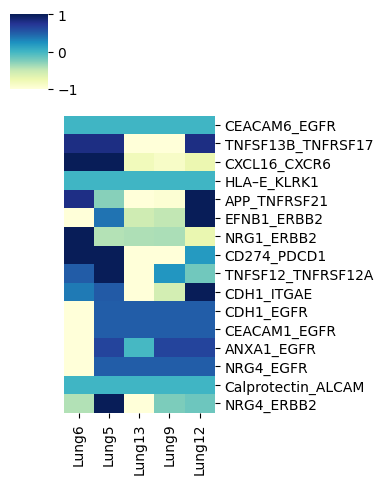

In [27]:

plt.figure(figsize = (3,5))
sns.clustermap(df_pivot,cmap='YlGnBu',cbar_kws={'shrink': 0.4}, figsize=(4,5),z_score=None,row_cluster=False, col_cluster=False,vmin=-1,vmax=1)
plt.ylabel("")
plt.tight_layout()
#plt.savefig(datap+'output/Figs/tumor_tcell_lr_heatmap.pdf')
plt.show()
        